# Importing required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import warnings
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Here we will also see how to utilize TPUs efficiently-

What are TPUs?
  - TPUs are tensor processing units developed by Google to accelerate operations on a Tensorflow Graph.
    - Each TPU packs up to 180 teraflops of floating-point performance and 64 GB of high-bandwidth memory onto a single board.
    - These are Google's custom-developed application-specific integrated circuits (ASICs) used to accelerate machine learning workloads.
  - TPUs were only available on Google cloud but now they are available for free in Colab.

In [ ]:
#tf.distribute.Strategy is a TensorFlow API to distribute training across multiple GPUs,
#multiple machines, or TPUs. Using this API, you can distribute your existing models and
#training code with minimal code changes.
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1



- Below, we define key configuration parameters we'll use in this example.
- To run on TPU, this example must be on Colab with the TPU runtime selected.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Specifying our training batch size
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

# Specifying the image size
IMAGE_SIZE = [224, 224]

# List containing class names, which will be used to index on our model output
# 0 = NORMAL, 1 = PNEUMONIA
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

tf.data.AUTOTUNE
- tf.data builds a performance model of the input pipeline
- runs an optimization algorithm to find a good allocation of its CPU budget across all parameters specified as **AUTOTUNE**.
- While the input pipeline is running, tf.data tracks time spent in each operation, so that these times can be fed to the optimization algorithm.

# Download dataset

Here the dataset is present in the TFRecord file format format:

What is TFRecord file format format ?
- A TFRecord file stores your data as a sequence of binary strings.
- It is Tensorflow’s own binary storage format.
- Advantages of tf.record format :
    - Binary data takes up less space on disk,
    - takes less time to copy
    - can be read much more efficiently from disk.
    - If you are working with large datasets, using a binary file format for storage of your data can have a significant impact on the performance of your import pipeline


In [ ]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

# Finding Number of data points in each class

In [ ]:
COUNT_NORMAL = len([filename for filename in train_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

print('Total Count of images:', COUNT_NORMAL+COUNT_PNEUMONIA )

Normal images count in training set: 1349
Pneumonia images count in training set: 3883
Total Count of images: 5232


# Applying Weghting on each class

In [ ]:
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT)  / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [ ]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls = AUTOTUNE)

# Spliting Our Data

In [ ]:
ds = ds.shuffle(10000)
train_ds = ds.take(4300)
val_ds = ds.skip(4300)

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)

Image shape:  (224, 224, 3)


# Loading Testing data

In [ ]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)

COUNT_NORMAL = len([filename for filename in test_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print("Normal images count in test set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in test_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print("Pneumonia images count in test set: " + str(COUNT_PNEUMONIA))

Normal images count in test set: 234
Pneumonia images count in test set: 390


In [ ]:
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds_batch = test_ds.batch(BATCH_SIZE)

# Buffered Prefetching

### What is Buffered Prefetching?
Buffered prefetching is a technique used in data pipelines to improve the performance of input/output (I/O) operations. It allows your program to load data from disk into memory while the model is training. This means that while the model is processing one batch of data, the next batch can be loaded into memory, reducing idle time.

### Why Use It?
Without prefetching, the model might have to wait for data to load from disk before it can continue training, which can slow down the training process significantly. By prefetching, you ensure that the model always has data ready to use, making the training more efficient.

## Caching and Memory Management

### Caching Data
Caching is when you store data in memory for faster access later. It’s useful when you want to quickly access the same data multiple times. However, for large datasets, caching everything in memory can lead to memory exhaustion, which can crash your program or slow down your system.


In [ ]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.

    ds = ds.cache()
    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_ds_batch = prepare_for_training(train_ds)
val_ds_batch = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds_batch))

# Data Visulaization

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

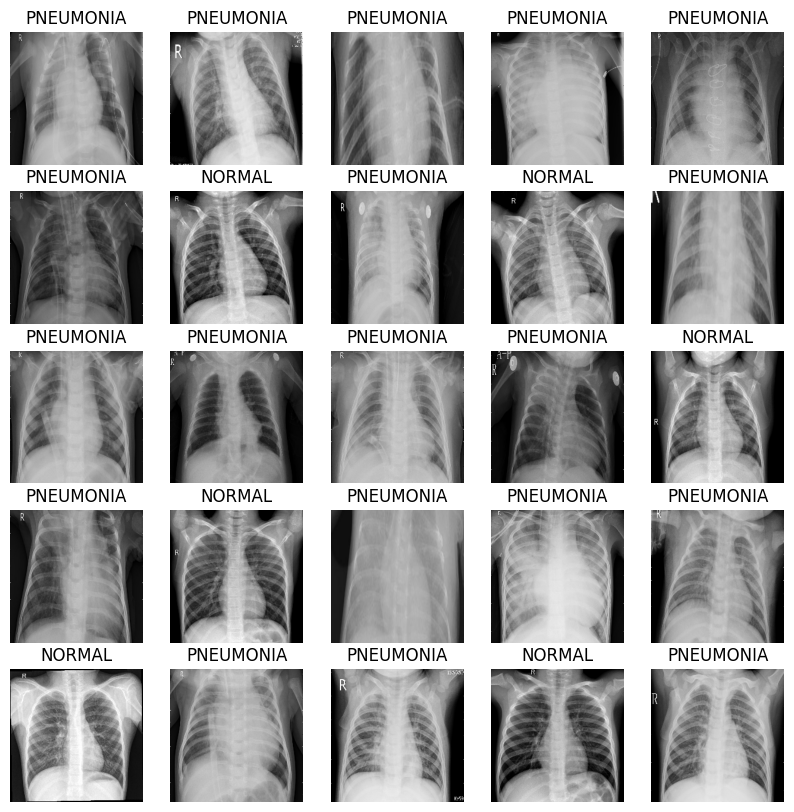

In [ ]:
#As the method takes in NumPy arrays as its parameters, call the numpy function on the
#batches to return the tensor in NumPy array form.
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
import tensorflow as tf

#import all necessary layers
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense

from tensorflow.keras import Model

In [ ]:
def build_model():

    mobilenet_model = tf.keras.applications.MobileNetV2(
        weights ='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    #Freezing the pretrained mobilenet layers except the last  layer
    # Known as fintuning the model

    for layer in mobilenet_model.layers[:-2]:
        layer.trainable = False


    # for layer in mobilenet_model.layers:
    #     layer.trainable = False


    #Output of base model
    x = mobilenet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation = "relu")(x)
    output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    pretrained_model = tf.keras.Model(inputs = mobilenet_model.input, outputs = output)

    return pretrained_model

In [ ]:
finetuned_mobilenet = build_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Visualizing our model layers and parameters
finetuned_mobilenet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 2,255,424 (8.60 MB)

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/Git/Pneumonia/Pnemonia_model.keras",
    save_best_only=True
)

# Create the EarlyStopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)


In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Training the model:

In [ ]:
with strategy.scope():
    finetuned_mobilenet = build_model()
    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]

    finetuned_mobilenet.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

    # Ensure the labels are in the correct format (0 and 1)
    def preprocess_dataset(dataset):
        # Assuming dataset yields (image, label) tuples
        return dataset.map(lambda x, y: (x, tf.cast(y, tf.int32)))

    train_ds_batch = preprocess_dataset(train_ds_batch)
    val_ds_batch = preprocess_dataset(val_ds_batch)

    history = finetuned_mobilenet.fit(
        train_ds_batch,
        epochs=10,
        validation_data=val_ds_batch,
        class_weight=class_weight,
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
    )


Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - binary_accuracy: 0.8367 - loss: 0.6475 - precision: 0.9373 - recall: 0.8370 - val_binary_accuracy: 0.7940 - val_loss: 0.4280 - val_precision: 0.7811 - val_recall: 0.9971 - learning_rate: 0.0100
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - binary_accuracy: 0.9242 - loss: 0.1949 - precision: 0.9778 - recall: 0.9196 - val_binary_accuracy: 0.7768 - val_loss: 0.5928 - val_precision: 0.7658 - val_recall: 1.0000 - learning_rate: 0.0089
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - binary_accuracy: 0.9390 - loss: 0.1635 - precision: 0.9840 - recall: 0.9336 - val_binary_accuracy: 0.7908 - val_loss: 0.5263 - val_precision: 0.7771 - val_recall: 1.0000 - learning_rate: 0.0079
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - binary_accuracy: 0.9389 - loss: 0.1515 - precision: 0.9828 - recall: 0.9348 - val_binary_accuracy: 0.8144 - val_loss: 0.4826 - val_precision: 0.7972 - val_recall: 1.0000 - learning_rate: 0.0071


# Plotting model performance


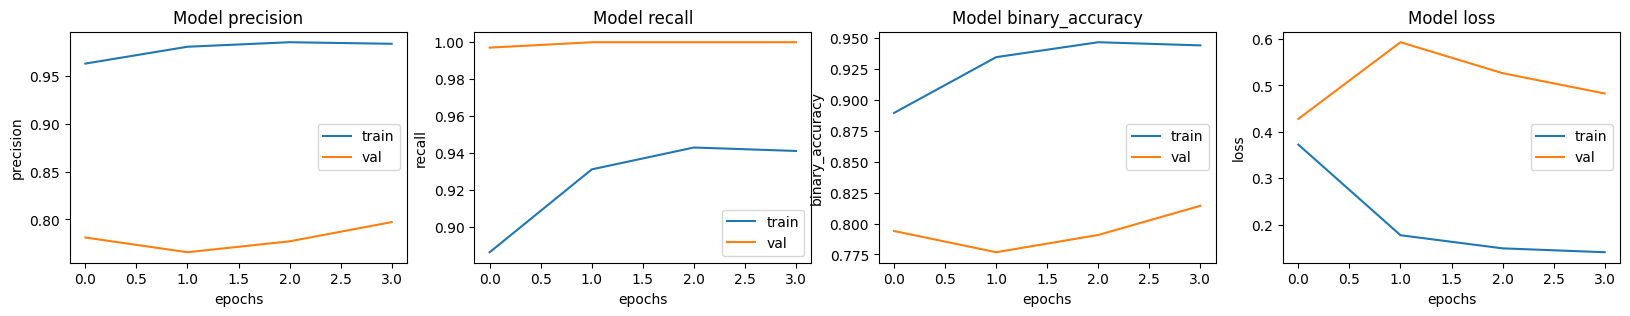

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

# Loading the Model



In [ ]:
loaded_mobilenet = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Git/Pneumonia/Pnemonia_model.keras")

# Evaluate model

In [ ]:
loaded_mobilenet.evaluate(test_ds_batch, return_dict=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - binary_accuracy: 0.3023 - loss: 2.1324 - precision: 0.2997 - recall: 0.6667


{'binary_accuracy': 0.6282051205635071,
 'loss': 1.112598180770874,
 'precision': 0.6270096302032471,
 'recall': 1.0}

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
This image is 3.48 percent NORMAL
This image is 96.52 percent PNEUMONIA
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


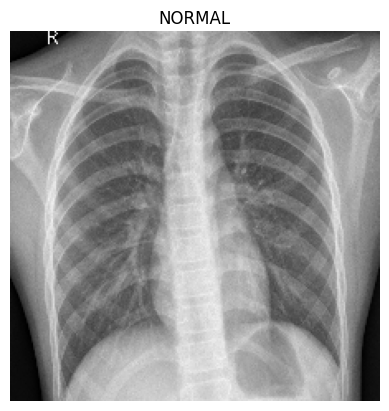

In [ ]:
for image, label in test_ds_batch.take(2):
      plt.imshow(image[2] / 255.0)
      plt.title(CLASS_NAMES[label[2].numpy()])
      plt.axis('off')
prediction = finetuned_mobilenet.predict(test_ds_batch.take(2))[2]
scores = [1 - prediction, prediction]
for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))
%time

# Confusion Matrix

In [ ]:
label_list = []
prediction_list = []

for image, label in test_ds:
    image = tf.expand_dims(image, axis = 0)
    prediction = finetuned_mobilenet.predict(image)
    label = tf.where(label, 1, 0)

    if prediction > 0.5 :
        prediction = 1
    else :
        prediction = 0

    prediction_list.append(prediction)
    label_list.append(label)

In [ ]:
test_confusion_matrix = tf.math.confusion_matrix(label_list, prediction_list)

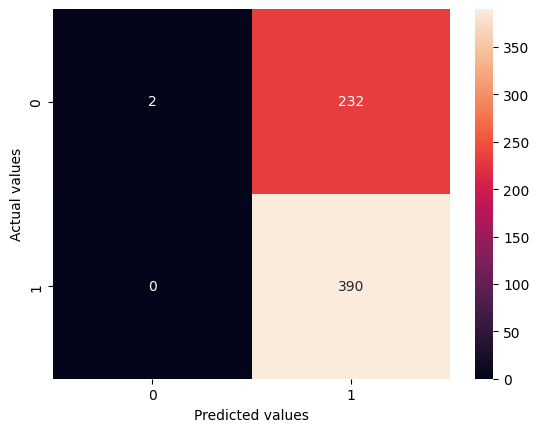

In [ ]:
ax = sns.heatmap(test_confusion_matrix, annot = True, fmt ='g')
ax.set(xlabel = 'Predicted values', ylabel = 'Actual values')

plt.show()

# GRADCAM (Gradient-weighted Class Activation Map) algorithm.
* It helps to find out the region on which **CNN is focusing on to predict particular class**.


In [ ]:
for i in range(len(finetuned_mobilenet.layers)):
    layer = finetuned_mobilenet.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i , layer.name , layer.output.shape)

4 expanded_conv_depthwise (None, 112, 112, 32)
5 expanded_conv_depthwise_BN (None, 112, 112, 32)
6 expanded_conv_depthwise_relu (None, 112, 112, 32)
7 expanded_conv_project (None, 112, 112, 16)
8 expanded_conv_project_BN (None, 112, 112, 16)


Last convolutional layer for GRADCAM is expanded_conv_project_BN

In [ ]:
last_conv_layer_name = finetuned_mobilenet.layers[8].name
last_conv_layer_name

'expanded_conv_project_BN'

In [ ]:
!pip install tf-explain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 768.4 kB/s eta 0:00:00


This image is 34.41 percent NORMAL
This image is 65.59 percent PNEUMONIA


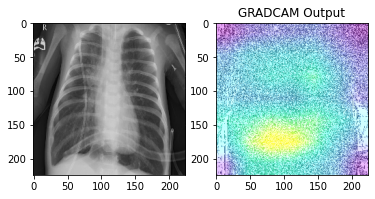

In [ ]:
from tf_explain.core.grad_cam import GradCAM
import random

for image, label in test_ds_batch.take(2):

    data = ([image[2].numpy()], None)
    # print('Original label',CLASS_NAMES[label[2].numpy()])
    image = image[2] / 255

prediction = finetuned_mobilenet.predict(test_ds_batch.take(2))[2]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, finetuned_mobilenet,class_index = 0)

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

axarr[0].imshow(image)
axarr[1].imshow(grid)
# axarr[0].title.set_text(f"{float(prediction)*100:.2f}% penumonia predicted")
axarr[1].title.set_text('GRADCAM Output')
plt.show()